In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bandits_utils import *

In [2]:
ratings = pd.read_table('ml-1m/ratings.dat', sep='::', 
                        names = ['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        encoding = 'latin1',
                        engine = 'python')
movies  = pd.read_table('ml-1m/movies.dat',  sep='::',
                        names = ['MovieID', 'Title', 'Genres'], 
                        encoding = 'latin1',
                        engine ='python')
users   = pd.read_table('ml-1m/users.dat',  sep='::', 
                        names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip'], 
                        encoding = 'latin1',
                        engine = 'python')

# Films with sufficient numbers of reviews
Let's just get those titles which have at least N reviews

The output is **ratings_topN**

In [3]:
N = 1000
ratings_count = ratings.groupby(by='MovieID', as_index=True).size()
# top_ratings = ratings_count.sort_values(ascending=False)[:N]
top_ratings = ratings_count[ratings_count>=N]
top_ratings.head(3)

MovieID
1     2077
11    1033
21    1356
dtype: int64

In [4]:
movies_topN = movies[movies.MovieID.isin(top_ratings.index)]
ratings_topN = ratings[ratings.MovieID.isin(top_ratings.index)]
print('Shape: {}'.format(ratings_topN.shape))
ratings_topN.head(3)

Shape: (305373, 4)


UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
3       1     3408       4  978300275
4       1     2355       5  978824291

In [5]:
n_users = ratings_topN.UserID.unique().shape[0]
n_movies = ratings_topN.MovieID.unique().shape[0]
print('Number of users = {} | Number of movies = {}'.format(n_users, n_movies))

Number of users = 6039 | Number of movies = 207


# Low Rank Matrix Factorization
build our model of users, the rating that user i assigns to movie j. We factor the user-movie matrix using low-rank matrix factorization: M = UV'

In [6]:
R_df = ratings_topN.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head(3)

MovieID  1     11    21    32    34    39    47    50    110   111   ...  \
UserID                                                               ...   
1         5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2         0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

MovieID  3527  3578  3623  3671  3702  3703  3751  3753  3755  3793  
UserID                                                               
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   5.0   0.0   0.0   0.0   0.0   0.0   0.0  

[3 rows x 207 columns]

In [7]:
Ratings = np.array(R_df) ##M = R_df.as_matrix()

### Non-negative matrix factorization (NMF)
Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X.

In [8]:
#Dimension used in the decomposition of the matrix Ratings
d = 1
#Selecting a user for the Linear UCB (removed from the matrix decomposition which is going to be the context for our algorithm)
user = 3

H = non_neg_decomp(np.delete(Ratings,user,0), d)

### Linear UCB algorithm + results ploting

In [9]:
iterations = 2000
final_rec, history, regret = LinUCB(T = iterations, user = Ratings[user], H = H, d = 1)

Text(0, 0.5, 'Regret')

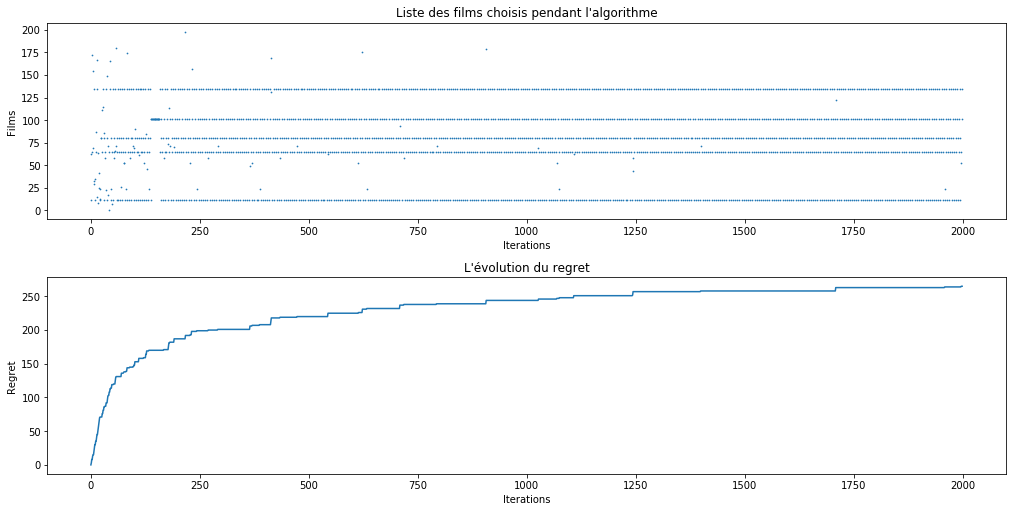

In [12]:
fig, axs = plt.subplots(2, 1, constrained_layout=True,figsize=(14,7))
axs[0].scatter(range(iterations),history,s=0.5)
axs[0].set_title("Liste des films choisis pendant l'algorithme")
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Films')

axs[1].plot(regret)
axs[1].set_title("L'évolution du regret")
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Regret')

### Influence of hyperparameter d

History of movies chosen and regret plot


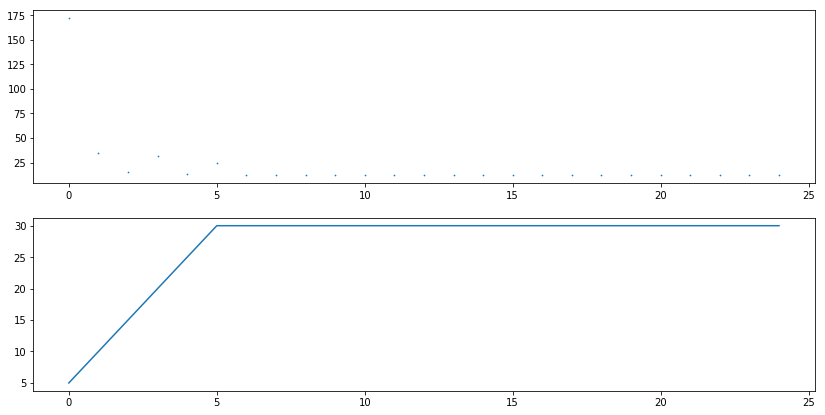

In [16]:
iterations = 25
user = 3
regret = []

for d in range (2,3):
    H = non_neg_decomp(np.delete(Ratings,user,0), d)
    _, history, temp = LinUCB(T = iterations, user = Ratings[user], H = H, d = d)
    regret.append(temp)

#plt.figure(figsize=(14, 7))
#for i in range(len(regret)):
 #   plt.plot(range(iterations), regret[i], label = "graphe du regret avec d = {}".format(i+1))
#plt.legend(prop={'size': 10})
#plt.grid()

print("History of movies chosen and regret plot")
plt.figure(figsize=(14, 7))
plt.subplot(2,1,1)
plt.scatter(range(iterations),history,s=0.5)
plt.subplot(2,1,2)
plt.plot(temp)